In [5]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [6]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartUTC,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29


In [8]:
## Vizualizacija
sns.set(rc={'figure.figsize':(20, 5)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartUTC'>

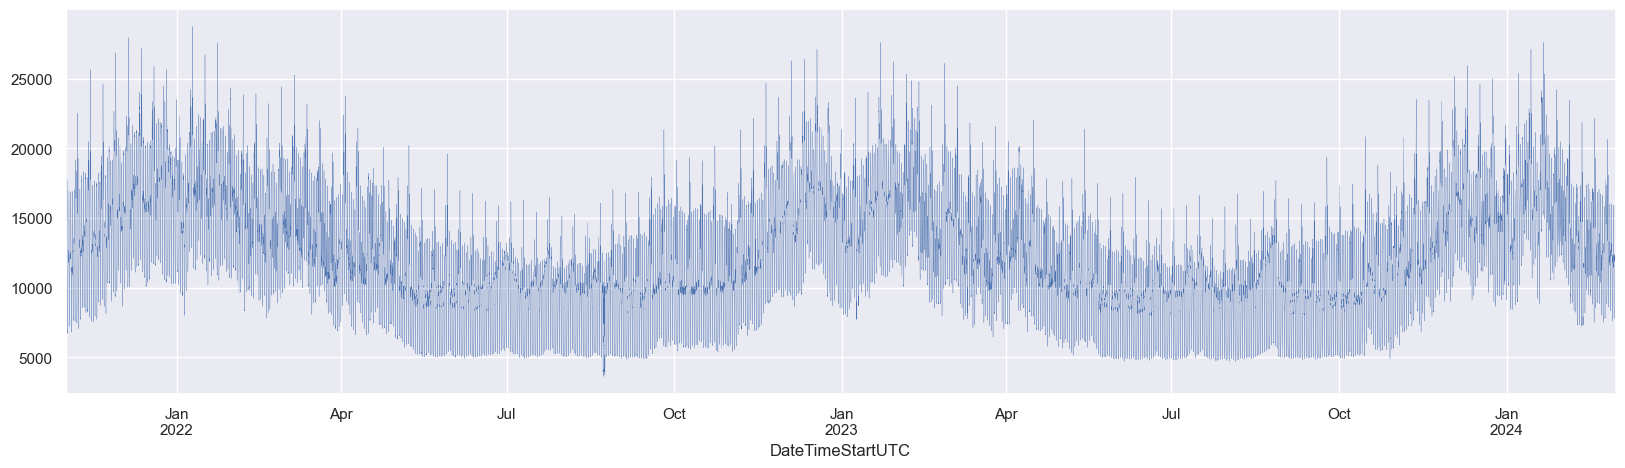

In [9]:
podatki['Odjem ACT'].plot(linewidth=0.2)

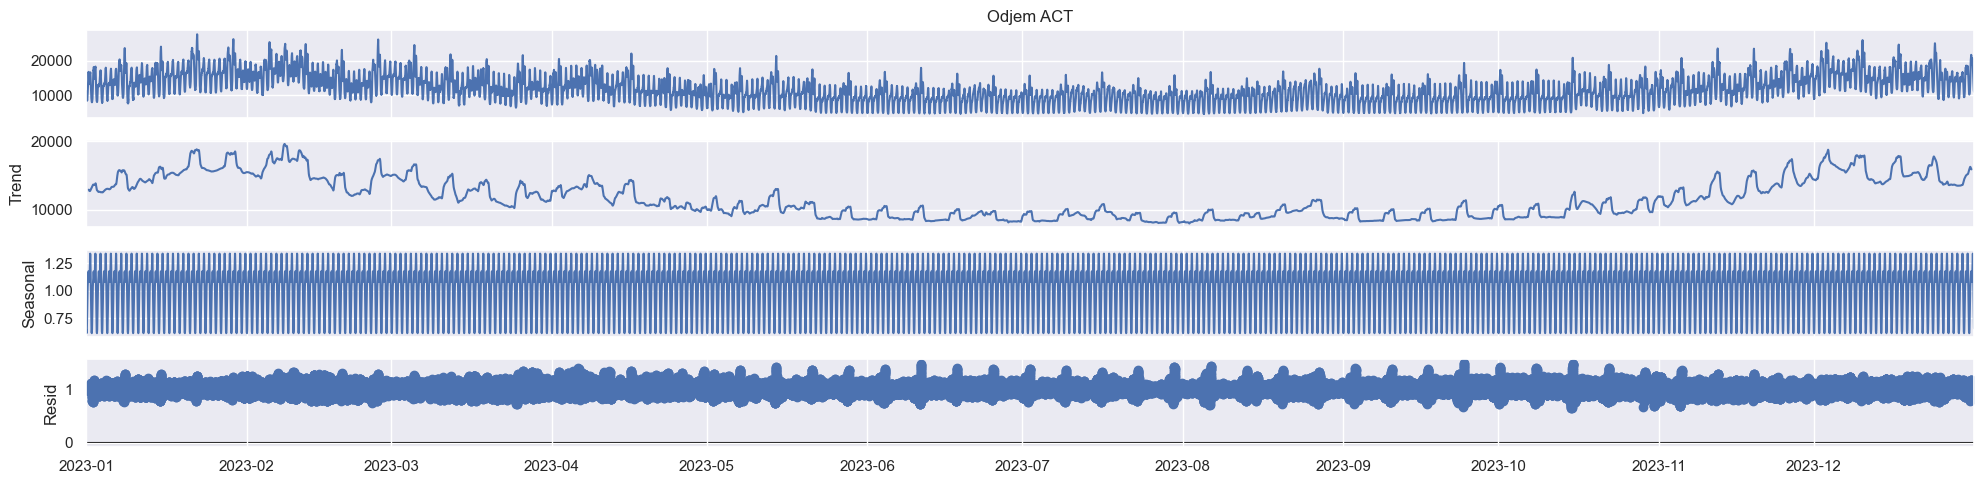

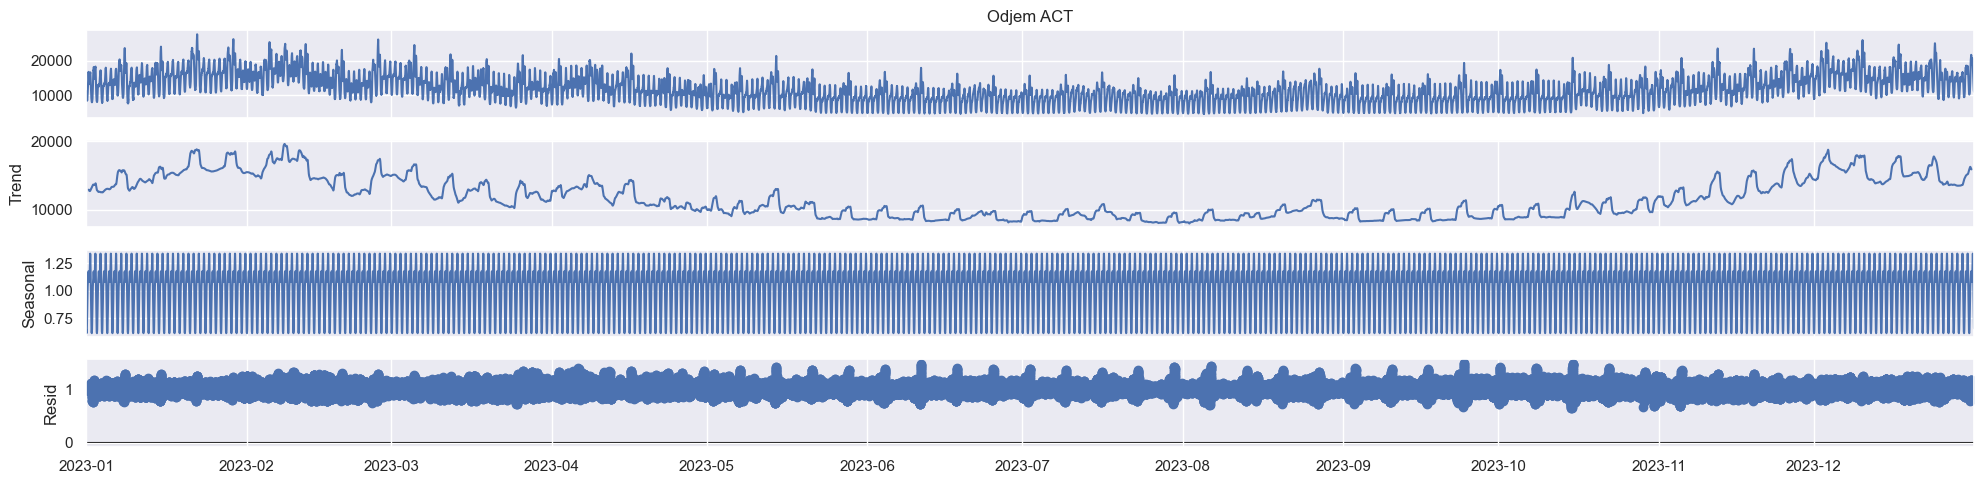

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

podatki_dec = podatki['Odjem ACT']
podatki_dec
decomp = seasonal_decompose(podatki.loc['2023', 'Odjem ACT'], model='multiplicative', period=96)
decomp.plot()

In [ ]:
# dolgoročno je nek trend
# zgleda kot da imamo sezonskost

In [21]:
# so podatki stacionarni? --> pomagamo si z Dickey-Fuller testom
    # Null Hypothesis: Data is non-stationary
    # Alternative Hypothesis: Data is stationary

from statsmodels.tsa.stattools import adfuller

def adfuller_test(y):
    adf_result = adfuller(y)

    print("ADF Statistic:", adf_result[0])
    print("P-Value:", adf_result[1])

adfuller_test(podatki.loc['2023-02-01':'2023-02-25', 'Odjem ACT'])

# p-value nam pravi da je stacionarno, ampak vemo da ni, ker imamo očitno sezonskost

ADF Statistic: -5.531007753580652
P-Value: 1.7876115261307236e-06


In [52]:
# diferenciramo:
df_diff = podatki['Odjem ACT'].diff(periods = 96)
# df_diff_2 = np.diff(df_diff, n = 1)
# df_diff_3 = np.diff(df_diff_2, n = 1)

train = df_diff['2023-01-01':'2023-12-15']
test = df_diff['2023-12-16']

In [63]:
ARIMA_model = SARIMAX(train, order=(4,2,4), seasonal_order=(1,0,0,96), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

residuals = ARIMA_model_fit.resid

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


KeyboardInterrupt: 

In [61]:
ARIMA_pred = ARIMA_model_fit.get_prediction(start=len(train), end=(len(train) + len(test))).predicted_mean
ARIMA_pred

2023-12-16 00:00:00    1040.100617
2023-12-16 00:15:00     998.546367
2023-12-16 00:30:00     953.831357
2023-12-16 00:45:00     906.635486
2023-12-16 01:00:00     858.112306
                          ...     
2023-12-16 23:00:00     707.813461
2023-12-16 23:15:00     707.455498
2023-12-16 23:30:00     707.044105
2023-12-16 23:45:00     706.760782
2023-12-17 00:00:00     706.455358
Freq: 15T, Name: predicted_mean, Length: 97, dtype: float64

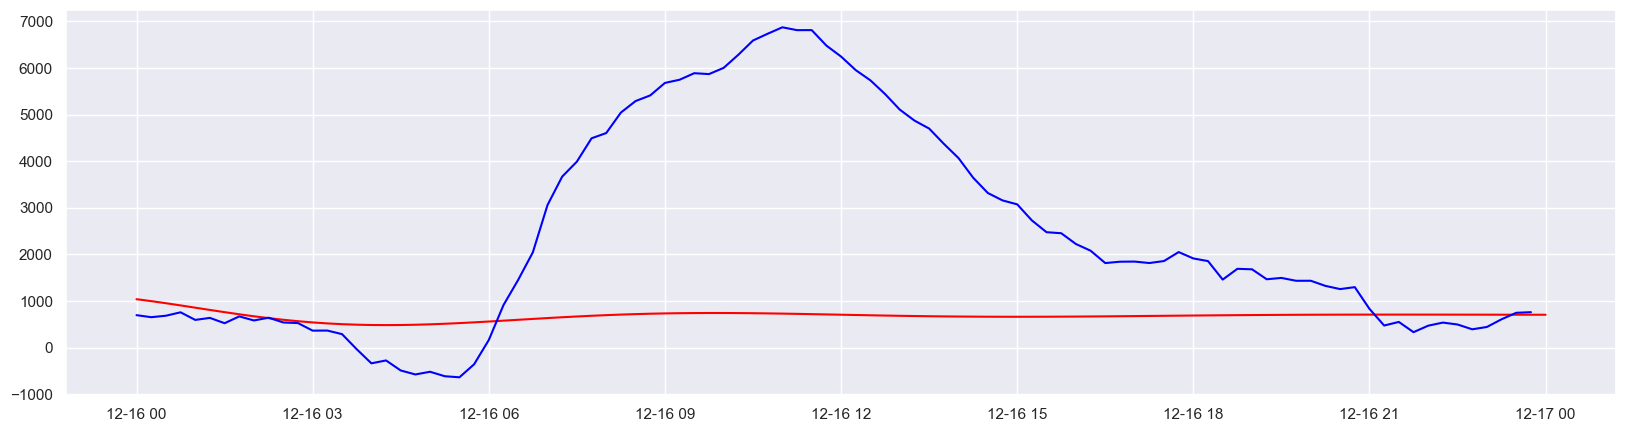

In [62]:
plt.plot(ARIMA_pred, color = 'red')
plt.plot(test, color = 'blue')